In [1]:
# Libraries
import pandas as pd #Data manipulation
import numpy as np #Data manipulation
import matplotlib.pyplot as plt # Visualization
import seaborn as sns #Visualization
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from collections import Counter
import re
plt.rcParams['figure.figsize'] = [7,4]
plt.rcParams['font.size'] =15
plt.rcParams['font.weight']= 'bold'
plt.style.use('seaborn-whitegrid')

/Users/a19028558/Desktop/transfer_accounts/akovyaz/learning_myself/env_school/lib/python3.8/site-packages/pandas/compat/__init__.py:109: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [53]:
df = pd.read_excel('/Users/a19028558/Desktop/CIAN_project/cian_data.xlsx')

In [54]:
df['rooms'] = df['Name'].str[:1].astype('int')

In [55]:
df['metres'] = df.Name.apply(lambda x: '.'.join(re.findall('\w+',x)[3:-1])).astype(float)

In [56]:
df['district'] = df['Area'].apply(lambda x: str(x).split('|')[1])

In [59]:
df = df[df['Price_for_meter'] < 1000000]
df = df[~df['Price'].isin(sorted(df.Price)[-3:])]

In [60]:
df.shape

(322, 8)

In [61]:
df_ = df[['metres','Price']].apply(pd.to_numeric)
# categorical_columns = ['rooms','district']
# df_ = pd.get_dummies(data = df, prefix = 'OHE', prefix_sep='_',
#                columns = categorical_columns,
#                drop_first =True,
#               dtype='int8')



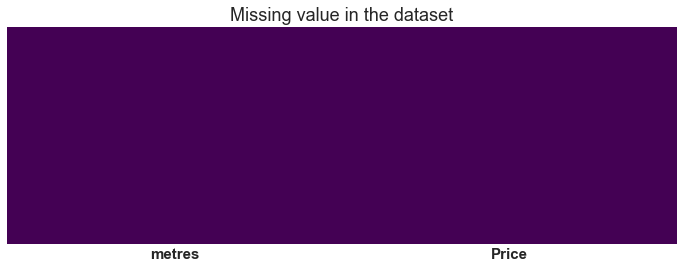

In [62]:
plt.figure(figsize=(12,4))
sns.heatmap(df_.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Missing value in the dataset');

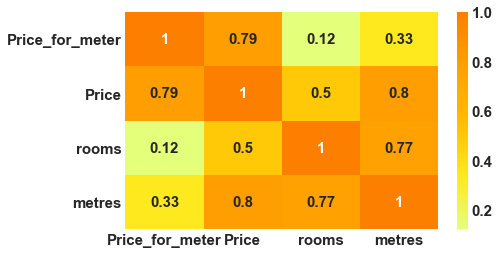

In [63]:
# correlation plot
corr = df.corr()
sns.heatmap(corr, cmap = 'Wistia', annot= True);

/Users/a19028558/Desktop/transfer_accounts/akovyaz/learning_myself/env_school/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/a19028558/Desktop/transfer_accounts/akovyaz/learning_myself/env_school/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


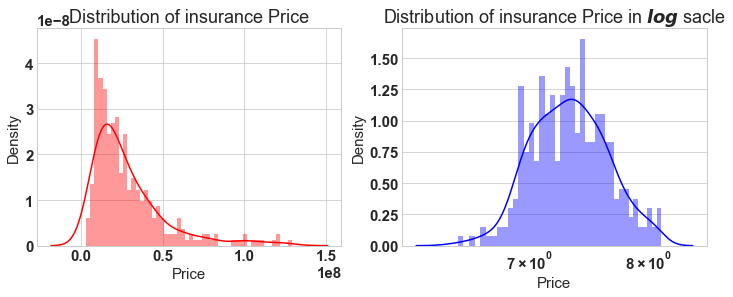

In [64]:
f= plt.figure(figsize=(12,4))

ax=f.add_subplot(121)
sns.distplot(df['Price'],bins=50,color='r',ax=ax)
ax.set_title('Distribution of insurance Price')

ax=f.add_subplot(122)
sns.distplot(np.log10(df['Price']),bins=40,color='b',ax=ax)
ax.set_title('Distribution of insurance Price in $log$ sacle')
ax.set_xscale('log');

In [65]:
df_['Price'] = np.log(df_['Price'])

In [129]:
X = df_.drop('Price',axis=1) # Independet variable
y = df_['Price'] # dependent variable

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=21)


In [130]:
# Step 1: add x0 =1 to dataset
X_train_0 = np.c_[np.ones((X_train.shape[0],1)),X_train]
X_test_0 = np.c_[np.ones((X_test.shape[0],1)),X_test]

# Step2: build model
theta = np.matmul(np.linalg.inv( np.matmul(X_train_0.T,X_train_0) ), np.matmul(X_train_0.T,y_train)) 

In [131]:
# The parameters for linear regression model
parameter = ['theta_'+str(i) for i in range(X_train_0.shape[1])]
columns = ['intersect:x_0=1'] + list(X.columns.values)
parameter_df = pd.DataFrame({'Parameter':parameter,'Columns':columns,'theta':theta})

In [132]:
# X_train = df[['metres']]
# y_train = df['Price']

In [133]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train) # Note: x_0 =1 is no need to add, sklearn will take care of it.

#Parameter
sk_theta = [lin_reg.intercept_]+list(lin_reg.coef_)
# parameter_df = parameter_df.join(pd.Series(sk_theta, name='Sklearn_theta'))
# parameter_df

In [134]:
sk_theta

[15.739007190979585, 0.0147811185871983]

In [135]:
theta_0 = pd.Series(sk_theta)[0]
theta_1 = pd.Series(sk_theta)[1]

In [136]:
def estimate_price(theta0, theta1, metres):
    metres = str(metres).replace(',','.').replace(' ','').strip('()')
    metres = float(metres)
    return np.exp(theta0 + theta1 * metres), np.exp(theta0 + theta1 * metres) / metres

In [144]:
metres = 11
estimate_price(theta_0, theta_1, metres)

(8053356.310138066, 732123.3009216423)

### GD

In [73]:
def get_theta0(mileage, price, theta0, theta1): # Часная производная Q0
    res = 0
    for i in range(len(mileage)):
        value = theta0 + theta1 * mileage[i]
        res += value - price[i]
    return res / len(mileage)

def get_theta1(mileage, price, theta0, theta1): # Часная производная Q1
    res = 0
    for i in range(len(mileage)):
        value = theta0 + theta1 * mileage[i]
        res += (value - price[i]) * mileage[i]
    return res / len(mileage)

Number of iterations 4276
Theta0 : -0.08855945511016798
Theta1 : 0.003641415829180391


/Users/a19028558/Desktop/transfer_accounts/akovyaz/learning_myself/env_school/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


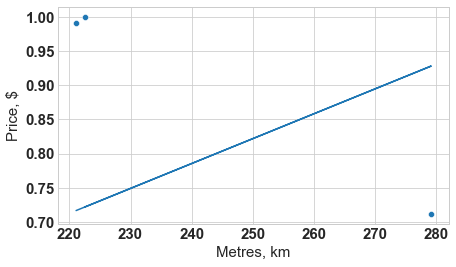

In [91]:
def gradient_descent(mileage, price):
    theta0 = 0 
    theta1 = 0
    learning_rate = 0.1
    i = 1
    while i < 10000: 
        tmp_theta0 = learning_rate * get_theta0(mileage, price, theta0, theta1)
        tmp_theta1 = learning_rate * get_theta1(mileage, price, theta0, theta1)
        theta0 -= tmp_theta0
        theta1 -= tmp_theta1
        if abs(tmp_theta0 < 0.000001) and abs(tmp_theta1) < 0.000001:
            break
        i += 1
    print('Number of iterations', i)
    return theta0, theta1

theta0, theta1 = gradient_descent(norm_mileage, norm_price)
theta0 = theta0 * max(price);
theta1 = theta1 * (max(price) / max(mileage))
print('Theta0 :', theta0)
print('Theta1 :', theta1)
msc = []
for i in range(len(mileage)):
    msc.append(theta0 + mileage[i] * theta1)
sns.scatterplot(mileage, price)
plt.plot(mileage, msc)
plt.ylabel("Price, $")
plt.xlabel("Metres, km");

In [77]:
def normalaze_data(data):
    normal = []
    for i in data:
        normal.append(i / max(data))
    return normal

In [78]:
norm_mileage = list(normalaze_data(df['metres']))
norm_price = list(normalaze_data(df['Price']))


In [93]:
metres = 40
estimate_price(theta0, theta1, metres)

0.05709717805704766

In [80]:
x = np.array((mileage)).reshape(-1,1)
y = np.array(price).reshape(-1,1)

In [81]:
x = np.c_[np.ones((x.shape[0], 1)), x]

In [82]:
w = np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)
w

array([[ 2.09477491],
       [-0.00495687]])

In [83]:
theta0 = w[0][0]
theta1= w[1][0]

In [94]:
metres = 40
np.exp(estimate_price(theta0, theta1, metres))

1.0587586935091462

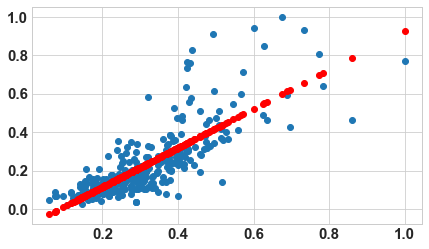

loss =  0.01132366


In [85]:
from IPython.display import clear_output
import torch

x = torch.tensor(norm_mileage, dtype=torch.float32)
y = torch.tensor(norm_price, dtype=torch.float32)

w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

for i in range(1000):
    y_pred = w * x + b
    loss = torch.mean((y_pred - y)**2)
    loss.backward()

    w.data -= 0.5 * w.grad.data
    b.data -= 0.5 * b.grad.data
    
    #zero gradients
    w.grad.data.zero_()
    b.grad.data.zero_()
    
    if (i+1)%3==0:
        clear_output(True)
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.scatter(x.data.numpy(), y_pred.data.numpy(), color='red')
        plt.show()

        print("loss = ", loss.data.numpy())
        if loss.data.numpy() < 0.0001:
            break

In [89]:
theta0 = b * max(price)
theta1 = w * (max(price) / max(mileage))

theta0, theta1

(tensor([-0.0887], grad_fn=<MulBackward0>),
 tensor([0.0036], grad_fn=<MulBackward0>))

In [169]:
df_orig = pd.read_excel('~/Desktop/CIAN_project/cian_data.xlsx')
df_orig.drop('Unnamed: 0', axis=1, inplace=True)

In [200]:
df_orig_ = df_orig[['Price', 'Subway', 'Area', 'links']]
map_dict = {}
for idx in df_orig_.index: 
    map_dict[idx] = ' '.join(str(df_orig_.iloc[idx]).split())[:-22]

In [ ]:
import telebot
from telebot.types import InlineKeyboardMarkup, InlineKeyboardButton

TELEGRAM_TOKEN = '1818315002:AAEnKKoy838i7RIQcygJa2DVSFiUA1pzTfY'

bot = telebot.TeleBot(TELEGRAM_TOKEN)

@bot.message_handler(func=lambda message: True)
def message_handler(message):
    if message.text == '/start' or message.text == '/go':
        bot.send_message(message.chat.id, "Введите размер квартиры в метрах...")
    else:
        try:
            prices = estimate_price(theta_0, theta_1, message.text)
            bot.send_message(message.chat.id, f'''Рыночная стоимость квартиры: 
{int(prices[0]) / 1000}р
Цена за квадратный метр {int(prices[1]) / 1000}р ''')
        except:
            bot.send_message(message.chat.id, "Введите размер квартиры в метрах корректно!")
        
        
        
bot.polling(none_stop=True)    